In [9]:
import numpy as np
import os
import mne
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import butter, sosfiltfilt, sosfreqz, welch
import wfdb
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

import warnings
warnings.filterwarnings("ignore")

## Read Data into memory
Dataset is from the [EEG Motor Movement/Imagery dataset](https://www.physionet.org/content/eegmmidb/1.0.0/). I downloaded it from the website and imported it into Kaggle to make it easier to download, as the original link has a very slow download speed. Users must have access to Kaggle to use the Kaggle API to download the dataset. The notebook can be modified below to add the Kaggle username and key if the user doesn't want to change any environment variable.


In [ ]:
# Kaggle authentication info, add if not already accessible on path
username = None
key = None


if username is not None and os.environ['KAGGLE_KEY'] is not None:
    os.environ['KAGGLE_USERNAME'] = username
    os.environ['KAGGLE_KEY'] = key
    
api = KaggleApi()
api.authenticate()

# Download dataset
dataset_name = "matthewalegrado/motor-imagery-dataset"
api.dataset_download_files(dataset_name, path=".", unzip=True)

In [14]:
# Data parameters
num_subjects = 50  # Lower this if Python exceeds memory capacity, there are 109 total subjects
num_trials = 14
num_channels = 64
num_timepoints = 30000
subject_data = np.zeros((num_subjects,num_trials,num_channels,num_timepoints))

# Read all of our data into workspace
mne.set_log_level("ERROR")
path = './files/'

for subject in range(1, num_subjects+1):
    for trial in range(1,num_trials+1):
        file = path + f'/S{subject:03}/S{subject:03}R{trial:02}.edf'
        try:
            with mne.io.read_raw_edf(file) as data:
                # Load data into subject_data np array
                raw_data = data.get_data()
                # Zero pad if this is a one-minute sample
                if raw_data.shape[1] != num_timepoints:
                    subject_data[subject-1][trial-1] = np.pad(raw_data,((0,0),(0,num_timepoints - raw_data.shape[1])),'empty') # Add 9760 zero-padding to the right side of raw_data
                else:
                    subject_data[subject-1][trial-1] = raw_data
                # you can get the metadata included in the file and a list of all channels:
                info = data.info
                channels = data.ch_names
        except FileNotFoundError:
            print(f"{file} not found, skipping.")

In [15]:
info

<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>

In [40]:
fs = 160  # From info variable, sampling frequency

In [11]:
channels

['Fc5.',
 'Fc3.',
 'Fc1.',
 'Fcz.',
 'Fc2.',
 'Fc4.',
 'Fc6.',
 'C5..',
 'C3..',
 'C1..',
 'Cz..',
 'C2..',
 'C4..',
 'C6..',
 'Cp5.',
 'Cp3.',
 'Cp1.',
 'Cpz.',
 'Cp2.',
 'Cp4.',
 'Cp6.',
 'Fp1.',
 'Fpz.',
 'Fp2.',
 'Af7.',
 'Af3.',
 'Afz.',
 'Af4.',
 'Af8.',
 'F7..',
 'F5..',
 'F3..',
 'F1..',
 'Fz..',
 'F2..',
 'F4..',
 'F6..',
 'F8..',
 'Ft7.',
 'Ft8.',
 'T7..',
 'T8..',
 'T9..',
 'T10.',
 'Tp7.',
 'Tp8.',
 'P7..',
 'P5..',
 'P3..',
 'P1..',
 'Pz..',
 'P2..',
 'P4..',
 'P6..',
 'P8..',
 'Po7.',
 'Po3.',
 'Poz.',
 'Po4.',
 'Po8.',
 'O1..',
 'Oz..',
 'O2..',
 'Iz..']

### Read the annotations file for event timesteps
The events correspond to when the subject was asked to do a specific task, which varied based on trial. The dataset link has the full list, but the main thing we were interested in was T0 vs. T1/T2. T0 was a resting event, giving the subjects a short break. The other two are events corresponding to motor movement, whether real or imagined.

An annotation file exists for each subject's individual trials and tells us when each event occured. Here I made a function to read it from the data folder and displayed an example trial's annotations. We can see that each event lasts around 4 seconds and can use the sample information to get the timestamp.

In [ ]:
def read_annotations(subject,trial):
    """
    Read an annotations file and return the annotations based on selected subject and trial.
    """
    file_path =  path + f"/S{subject:03}/S{subject:03}R{trial:02}.edf"
    annotations = wfdb.rdann(file_path,'event')
    return annotations

In [17]:
import wfdb

# Specify the path to the .event file (without the extension)
subject = 1
trial = 3

file_path = path + f"S{subject:03}/S{subject:03}R{trial:02}.edf"
annotations = wfdb.rdann(file_path,'event')

# Print annotation sample times
print(annotations.sample)

# Print annotation labels
print(annotations.aux_note)

[  672  1328  2000  2656  3328  3984  4656  5312  5984  6640  7312  7968
  8640  9296  9968 10624 11296 11952 12624 13280 13952 14608 15280 15936
 16608 17264 17936 18592 19264]
['T2 duration: 4.1', 'T0 duration: 4.2', 'T1 duration: 4.1', 'T0 duration: 4.2', 'T1 duration: 4.1', 'T0 duration: 4.2', 'T2 duration: 4.1', 'T0 duration: 4.2', 'T2 duration: 4.1', 'T0 duration: 4.2', 'T1 duration: 4.1', 'T0 duration: 4.2', 'T1 duration: 4.1', 'T0 duration: 4.2', 'T2 duration: 4.1', 'T0 duration: 4.2', 'T1 duration: 4.1', 'T0 duration: 4.2', 'T2 duration: 4.1', 'T0 duration: 4.2', 'T2 duration: 4.1', 'T0 duration: 4.2', 'T1 duration: 4.1', 'T0 duration: 4.2', 'T1 duration: 4.1', 'T0 duration: 4.2', 'T2 duration: 4.1', 'T0 duration: 4.2', 'T1 duration: 4.1']


### Example: Subject 1, Trial 3 and 4
During trial 3, subject 1 is asked to move either the left or right fist, corresponding to T1 and T2 events. For the next trial, subject 1 is asked the same but to imagine instead of actually moving their fists. Here I plotted some of the EEG data to visualize it. The events are the vertical dashed lines: T0 is green, T1 is red, and T2 is cyan.

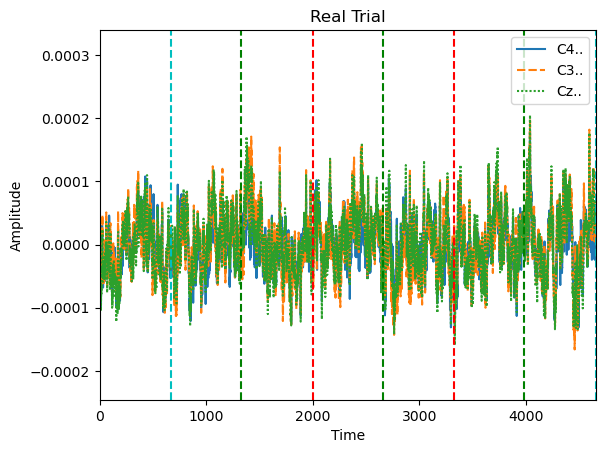

In [28]:
# Example time plot of the 64 channel data
motor_channels = ['C4..','C3..','Cz..']
df = pd.DataFrame(subject_data[0][2].T,columns=channels)  # Transpose to have 64 channels as columns
df.replace([np.inf, -np.inf], np.nan, inplace=True)
selected_channels = df[motor_channels]  # Filter by channel

sns.lineplot(data=selected_channels)

samples = annotations.sample
notes = annotations.aux_note

for sample, note in zip(samples,notes):   # Add event lines
    if 'T0' in note:
        color = 'g'
    elif 'T1' in note:
        color = 'r'
    elif 'T2' in note:
        color = 'c'
    else:
        color = 'y'
            
    plt.axvline(x=sample, color=color, linestyle='--')

plt.xlim(0, annotations.sample[6])
    
plt.title("Real Trial")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

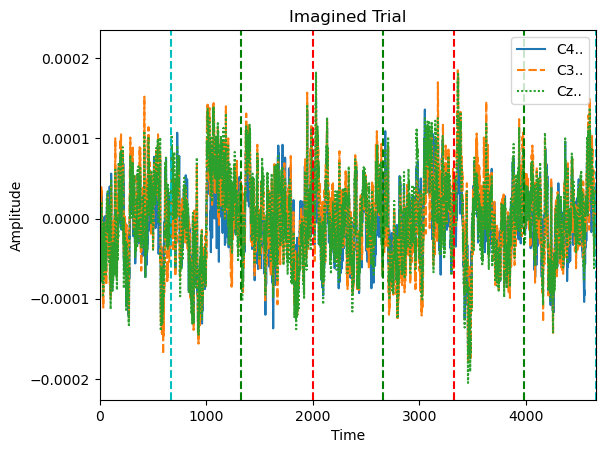

In [29]:
# Example time plot of the 64 channel data
motor_channels = ['C4..','C3..','Cz..']
df = pd.DataFrame(subject_data[0][3].T,columns=channels)  # Transpose to have 64 channels as columns
df.replace([np.inf, -np.inf], np.nan, inplace=True)
selected_channels = df[motor_channels]  # Filter by channel

sns.lineplot(data=selected_channels)

samples = annotations.sample
notes = annotations.aux_note

for sample, note in zip(samples,notes):   # Add event lines
    if 'T0' in note:
        color = 'g'
    elif 'T1' in note:
        color = 'r'
    elif 'T2' in note:
        color = 'c'
    else:
        color = 'y'
            
    plt.axvline(x=sample, color=color, linestyle='--')

plt.xlim(0, annotations.sample[6])
    
plt.title("Imagined Trial")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

The visualization isn't very helpful since it is very noisy, but it is good to know that we can easily choose each event since they are all roughly 4 seconds. With `fs = 160`, we can choose 640 datapoints after each event to get the data for an entire event, which we will use later for classification.

### Filtering Trials
To help make these EEGs more useful, we decided to use a simple Butterworth bandpass filter to look at specific frequency bands. Specifically, Alpha and Beta waves are known to be associated with motor imagery, so we selected those along with the Gamma range. This corresponds to 8-12 Hz, 13-30 Hz, and 30-80 Hz, respectively. We could not go higher since we are sampling at 160 Hz.

Below are functions to visualize the trials after filtering with the Butterworth filter. I also tried different channel combinations to visualize the premotor cortex and somatosensory cortex along with the motor cortex.

In [33]:
def butter_bandpass(lowcut, highcut, fs, order = 2):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
        return sos

In [34]:
def plot_filtered_trial(subject_data, subject=1, trial=3, epoch_len=4, epoch_start=None,
                    motor_channels=['C4..','C3..','Cz..'],plot_title="Title"):
    """
    Display 3-plot of a given subject and trial using bandpass filter on Alpha, Beta, and Gamma ranges.
    For event colors, T0 is green, T1 is red, T2 is cyan.

    Args:
        subject_data (np.array): The dataset we are working with.
        subject (int): Which subject to look at (1-indexed).
        trial (int): Which subject to look at (1-indexed).
        epoch_len (int): How many epochs to look at, where one epoch is one target (T0,T1,T2).
        epoch_start (int): Which epoch to start at.
        motor_channels (list of str): Which channels to look at. Refer to the printed channels variable in cell above 
            for the list.
        plot_title (str): Title of the full figure.
        
    Returns: nothing
    """
   
    num_channels = len(motor_channels)
    
    df = pd.DataFrame(subject_data[subject-1][trial-1].T,columns=channels)  # Transpose to have 64 channels as columns

    # Create a figure and a set of subplots (e.g., 2 rows, 2 columns)
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,12))
    
    # Read the annotation file
    file_path =  path + f"S{subject:03}/S{subject:03}R{trial:02}.edf"
    annotations = wfdb.rdann(file_path,'event')
    samples = annotations.sample
    notes = annotations.aux_note

    selected_channels = df[motor_channels]

    sos_alpha = butter_bandpass(8, 12, fs, order = 10)
    sos_beta = butter_bandpass(13, 30, fs, order = 10)
    sos_gamma = butter_bandpass(30, 79, fs, order = 10)

    alpha_df = selected_channels.apply(lambda x: sosfiltfilt(sos_alpha, x))
    beta_df = selected_channels.apply(lambda x: sosfiltfilt(sos_beta, x))
    gamma_df = selected_channels.apply(lambda x: sosfiltfilt(sos_gamma, x))

    sns.lineplot(data=alpha_df,ax=axes[0])
    sns.lineplot(data=beta_df,ax=axes[1])
    sns.lineplot(data=gamma_df,ax=axes[2])

    titles = ['Alpha (8-12 Hz)','Beta (13-30 Hz)','Gamma (30-79 Hz)']

    for sample, note in zip(samples,notes):        
        if 'T0' in note:
            color = 'g'
        elif 'T1' in note:
            color = 'r'
        elif 'T2' in note:
            color = 'c'
        else:
            color = 'y'

        for i in range(3):
            if epoch_start is None or type(epoch_start) is not int:
                axes[i].set_xlim(0, samples[epoch_len-1]+20)
            else:
                axes[i].set_xlim(annotations.sample[epoch_start-1]-20, annotations.sample[epoch_start + epoch_len - 1]+20)
            axes[i].axvline(x=sample, color=color, linestyle='--', label=f't = {x}')
            axes[i].set_title(titles[i])

    plt.suptitle(plot_title, fontsize=16)
    plt.xlabel("Timesteps")
    plt.ylabel("Amplitude")
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

In [17]:
# Control whether to show or hide the big list of filtered time plots
time_plots = True

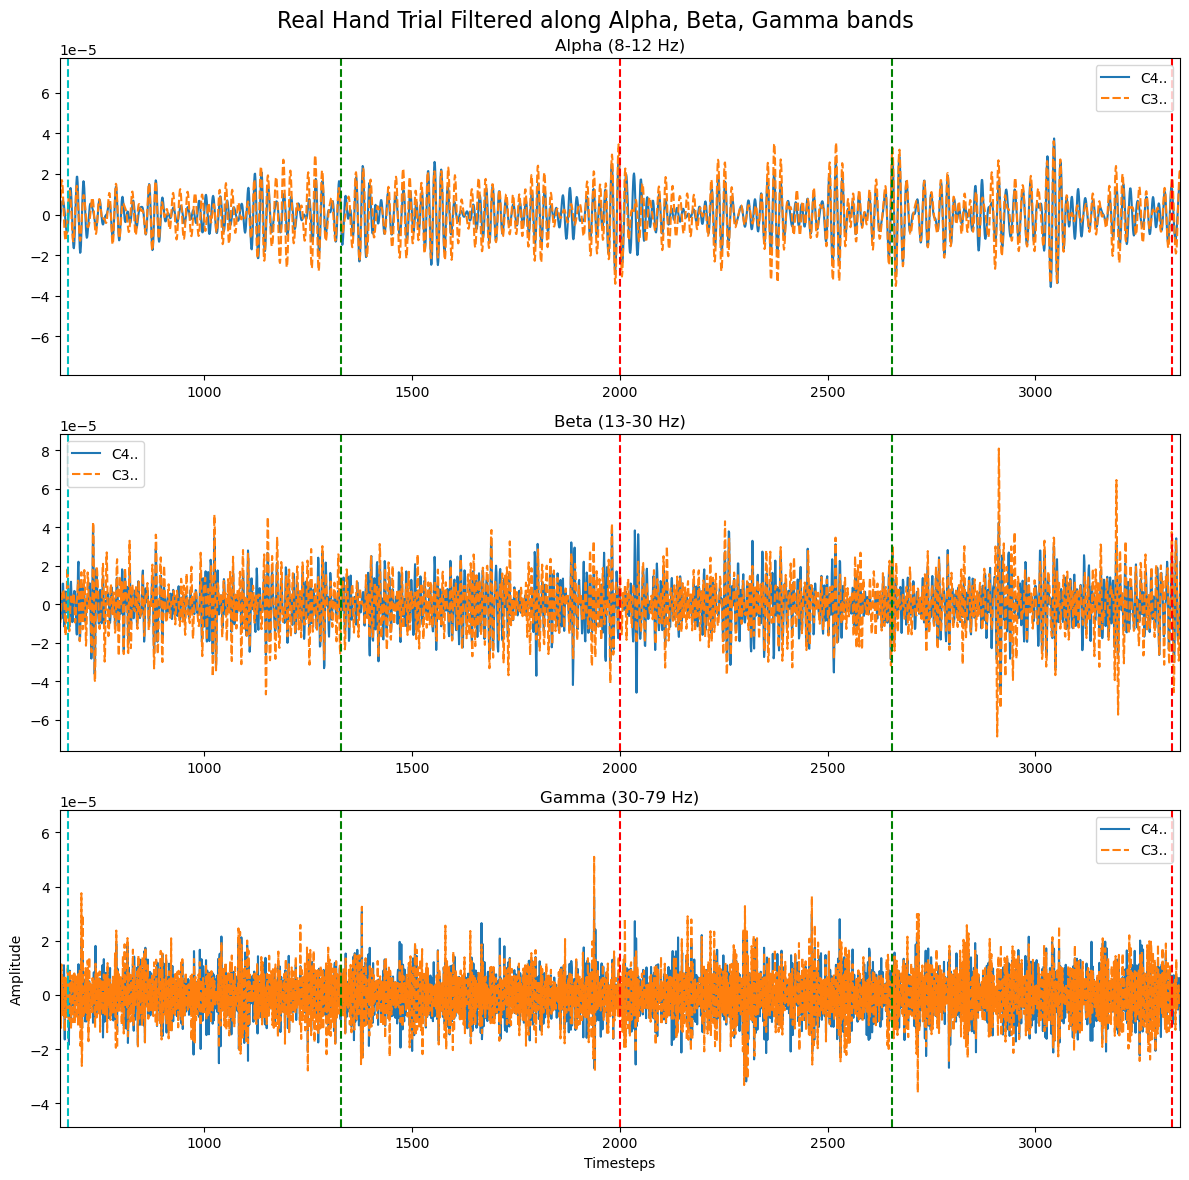

In [18]:
# filtered_trial is one-indexed, so for subject 001, you'd put subject=1 and whichever trial you wanted to look at. The 
# motor_channels can be selected, so you could add for example the channel 'Cz..' if you wanted, all of the channels are
# strings of length 4, padded with 1 or 2 periods at the end.
if time_plots:
    plot_filtered_trial(
        subject_data,
        subject=1,
        trial=3,
        motor_channels=['C4..','C3..','Cz..'],
        epoch_start=1,
        plot_title="Real Hand Trial Filtered along Alpha, Beta, Gamma bands")

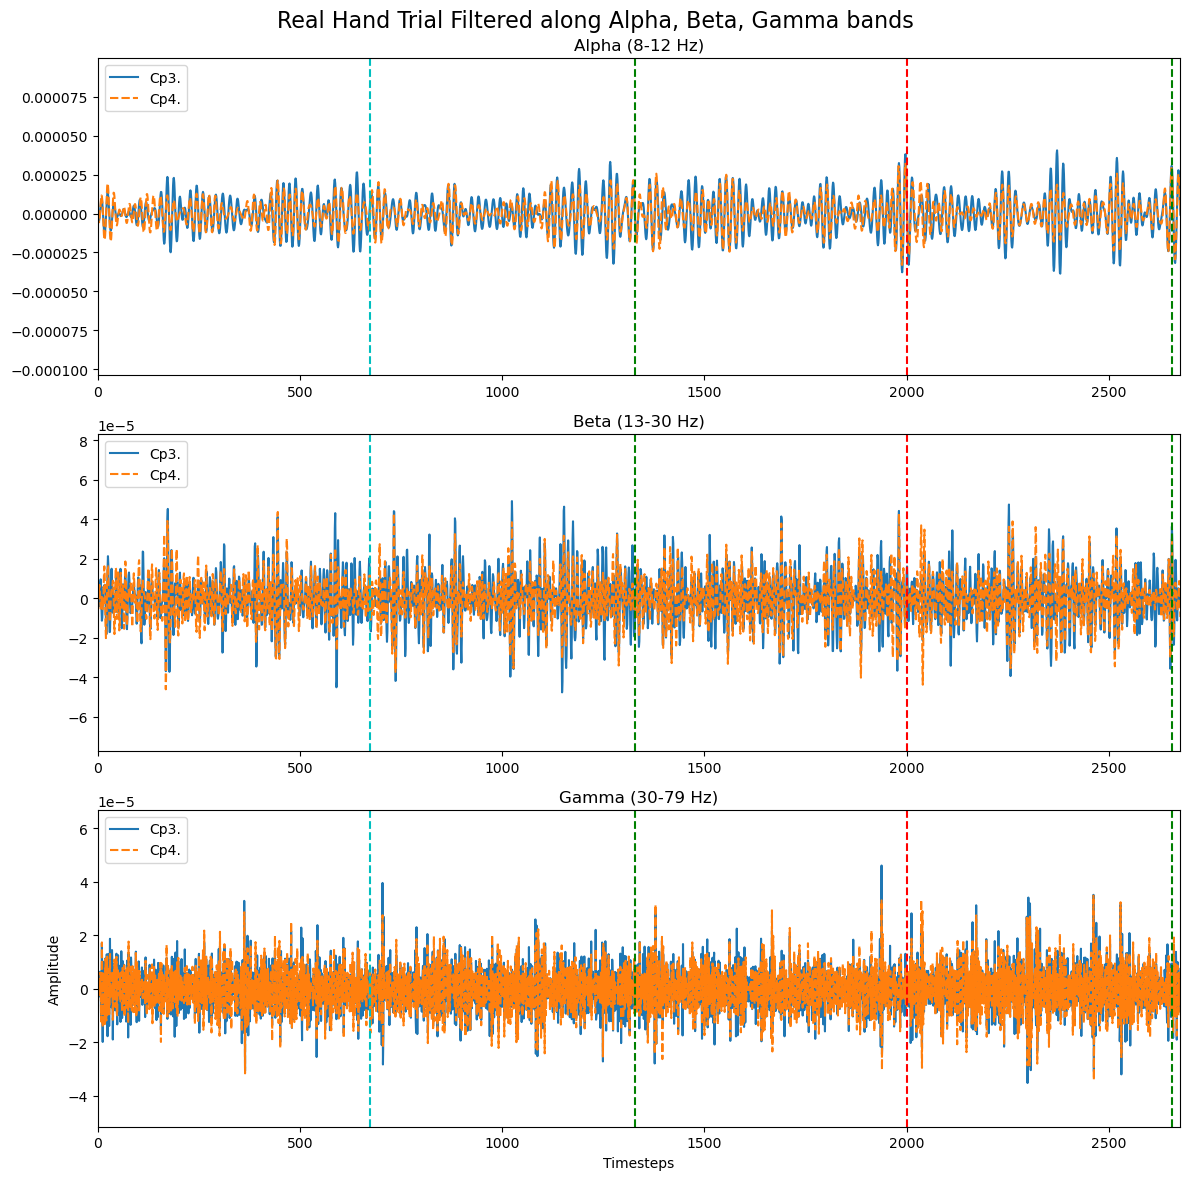

In [19]:
if time_plots:
    plot_filtered_trial(
        subject_data,
        subject=1,
        trial=3,
        motor_channels=['Cp3.','Cp4.'],
        plot_title="Real Hand Trial Filtered along Alpha, Beta, Gamma bands")

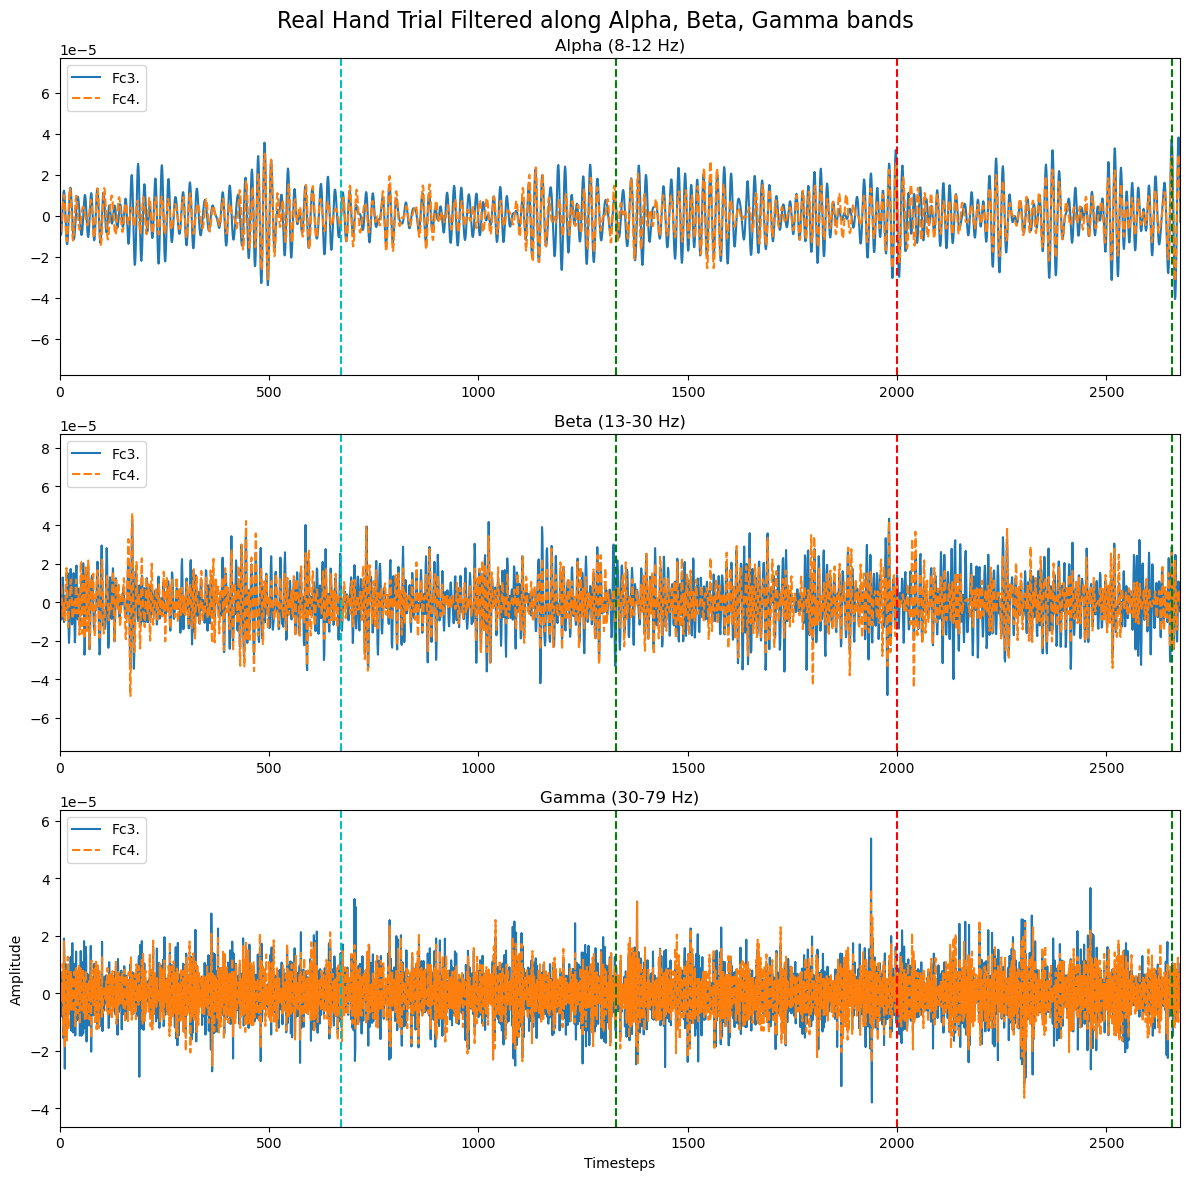

In [20]:
if time_plots:
    plot_filtered_trial(
        subject_data,
        subject=1,
        trial=3,
        motor_channels=['Fc3.','Fc4.'],
        plot_title="Real Hand Trial Filtered along Alpha, Beta, Gamma bands")

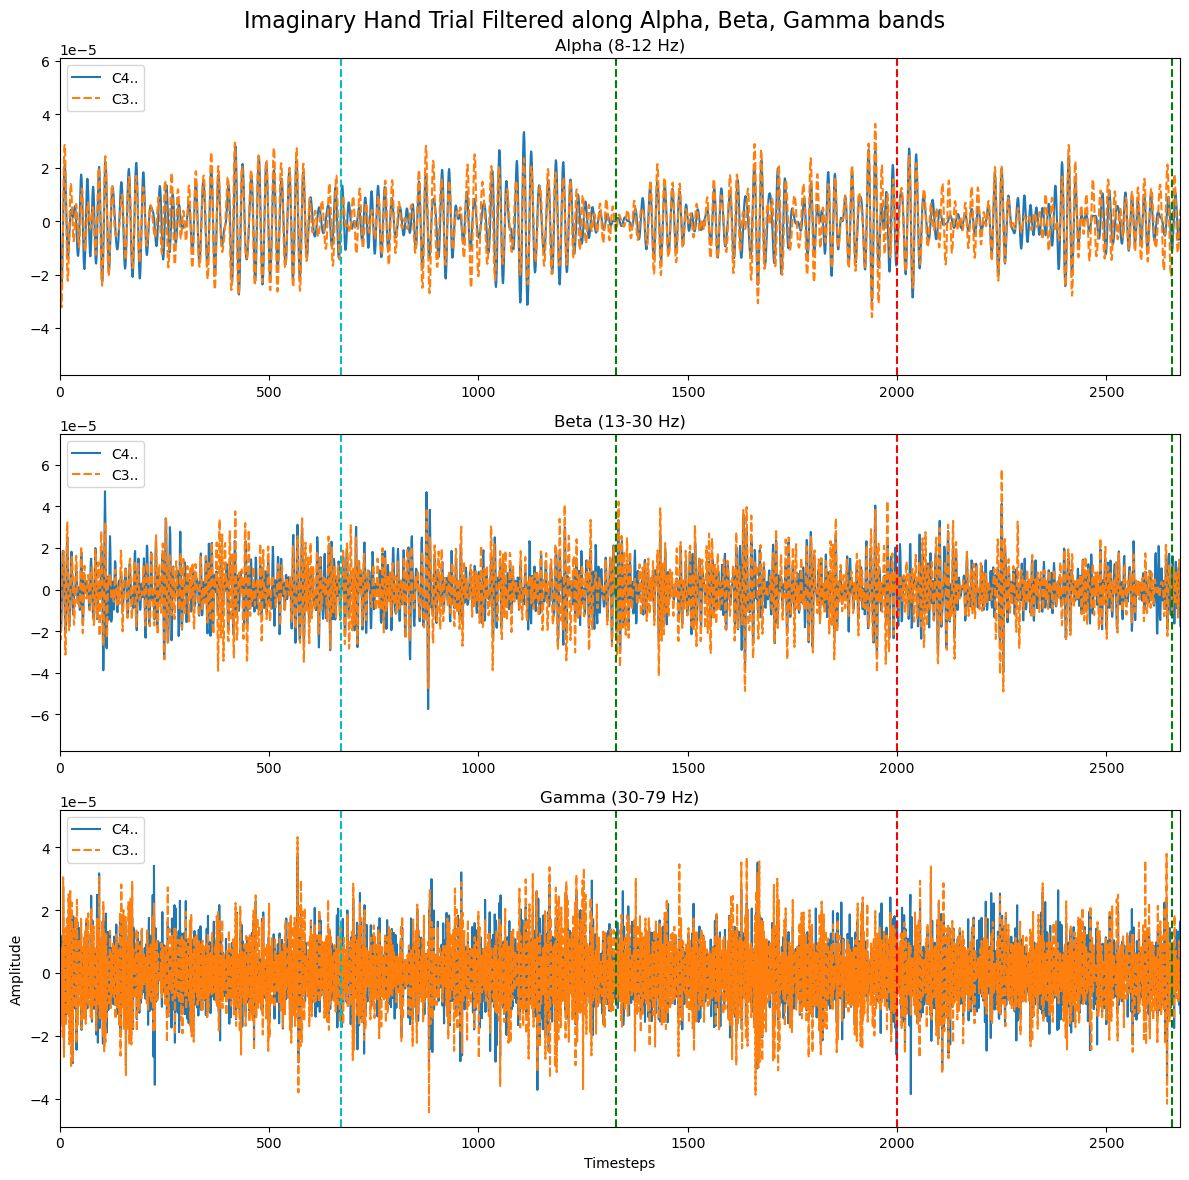

In [21]:
if time_plots:
    plot_filtered_trial(
        subject_data,
        subject=1,
        trial=4,
        motor_channels=['C4..','C3..'],
        plot_title="Imaginary Hand Trial Filtered along Alpha, Beta, Gamma bands")

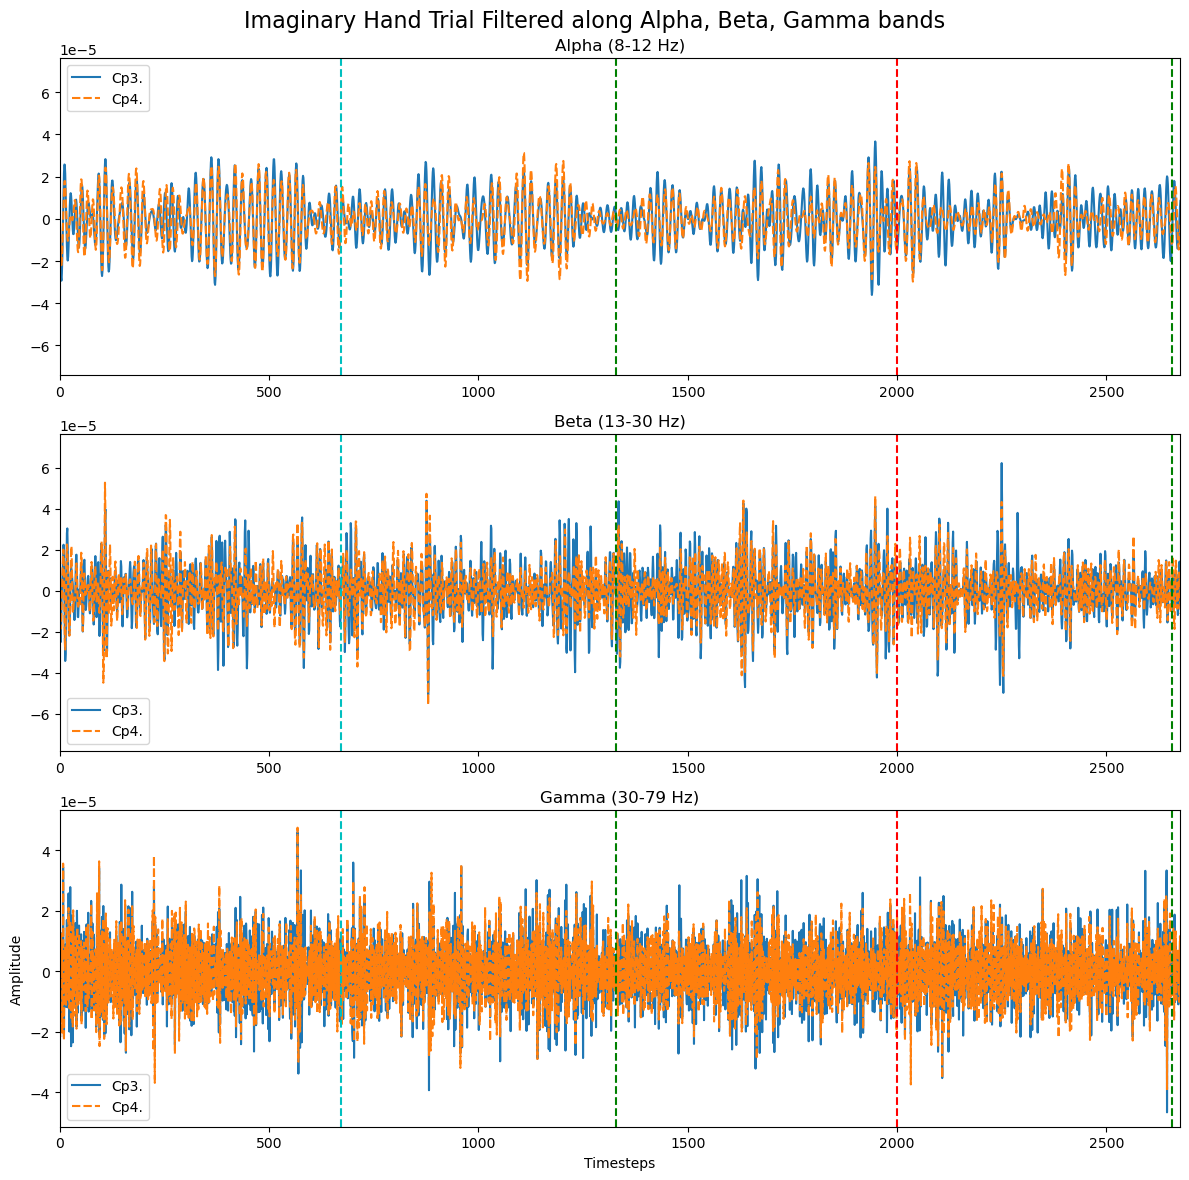

In [22]:
if time_plots:
    plot_filtered_trial(
        subject_data,
        subject=1,
        trial=4,
        motor_channels=['Cp3.','Cp4.'],
        plot_title="Imaginary Hand Trial Filtered along Alpha, Beta, Gamma bands")

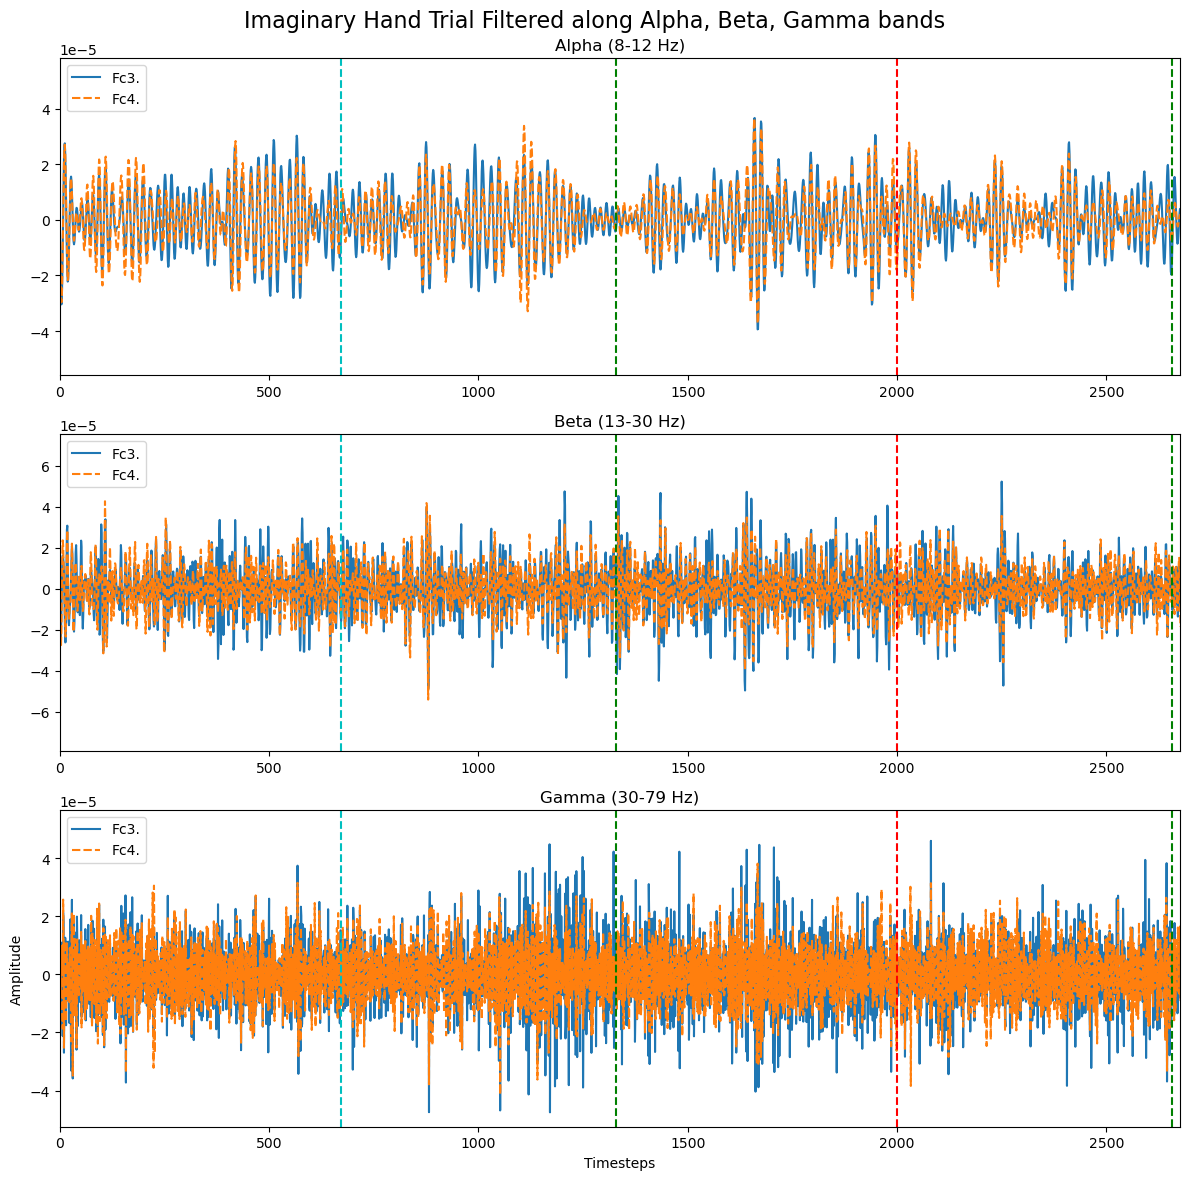

In [23]:
if time_plots:
    plot_filtered_trial(
        subject_data,
        subject=1,
        trial=4,
        motor_channels=['Fc3.','Fc4.'],
        plot_title="Imaginary Hand Trial Filtered along Alpha, Beta, Gamma bands")

## Classifying EEG data with SVM
This section explores training a SVM classifier that can classify between imagined and real motor movement of individual subjects. I formatted the data with labels of each epoch being either from the imaginary or the real trial. Each epoch has SxC features, where S is the number of samples in the 4 seconds after each T-code, and C is the number of channels. 

I decided to use the SVM classifier as each data sample will have SxC features, meaning that since each subject only has a relatively small number of 180 trials, there will be many more features than samples in our set. SVMs is particularly robust against high dimensional data with few data points, so it seemed like a very good fit.

Below is a function that formats the data for a single subject into a form that can be used to train the SVM, and the results of subject 1's classification with motor, premotor, and somatosensory channel selection.

In [41]:
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split

In [42]:
def format_data(data, subject, selected_channels='all', filter_bands=None):
    """
    Format training/testing data into a 2d array of size (E, SxC), where S is how many samples there are in 
    one event (+1 since the label is at index 0), C is the number of channels, and E is the number of 
    non-resting events. Each E will correspond to one sample for the SVM.
    
    Inputs:
        data (np.array): The 3-d data for a single subject, or the 4-d data for all subjects.
        subject (int): Which subject the data belongs to.
        selected_channels (optional, list or str): Which EEG channels to look at. Defaults to 'all'
        filter_bands (optional, tuple): The passbands for the filter.
    
    Returns: 
        formatted_data (np.array): The formatted data, in size (E, SxC).
        labels (list): The labels with -1 for imaginary and 1 for real movements.
    """
    df_list = []
    if selected_channels == 'all':
        selected_channels = channels  # Use channels global var for all channel selection
    if len(data.shape) > 3:
        data = data[subject-1]
        
    fs = 160
    if filter_bands is not None:
        lowcut, highcut = filter_bands
        sos = butter_bandpass(lowcut, highcut, fs, order = 10)
        
    for trial in data:
        df = pd.DataFrame(trial.T,columns=channels)
        if filter_bands is not None:
            df = df.apply(lambda x: sosfiltfilt(sos, x))
        df_list.append(df)

    time_between_codes = 4
    fs = 160
    samples_between_codes = fs*time_between_codes

    imaginary_vs_real = {}
    for i in range(3,15):
        if i % 2 == 1:
            imaginary_vs_real[i] = 'real'
        else:
            imaginary_vs_real[i] = 'imaginary'

    trial_iter = 1
    formatted_data = None
    labels = []
    
    for trial in df_list:
        try:
            # Label 1 as a real trial, 0 as imaginary trial
            if 'real' in imaginary_vs_real[trial_iter]:
                label = 1
            elif 'imaginary' in imaginary_vs_real[trial_iter]: 
                label = -1
            else:
                continue  # Skip the baselines, TODO check if we should use baselines somehow
        except KeyError:
#             print('Key',trial_iter,'not detected, skipping...')
            trial_iter += 1
            continue

        annotations = read_annotations(subject,trial_iter)
        events = annotations.sample
        codes = annotations.aux_note

    #     T0 = [(sample,aux_note) for (sample,aux_note) in zip(events,codes) if 'T0' in aux_note]
        T1 = [(sample,aux_note) for (sample,aux_note) in zip(events,codes) if 'T1' in aux_note]
        T2 = [(sample,aux_note) for (sample,aux_note) in zip(events,codes) if 'T2' in aux_note]

        # For given trial, extract T1 and T2 events, then format them for output
        
        for event,_ in T1:  # samples x channels x epochs (each event/epoch gets 1 row)
            new_data = trial[event:event+samples_between_codes][selected_channels]  # samples x channels
            output_data = np.array(new_data)
            sz_1,sz_2 = output_data.shape
            output_data = np.reshape(output_data,(sz_1,sz_2,1))  # Turn into 3d array
        
            labels.append(label)

            if formatted_data is None:
                formatted_data = output_data
            else:
                formatted_data = np.concatenate([formatted_data, output_data],axis=2)
                
        for event,_ in T2:  # samples x channels x epochs (each event/epoch gets 1 row)
            new_data = trial[event:event+samples_between_codes][selected_channels]  # samples x channels
            output_data = np.array(new_data)
            sz_1,sz_2 = output_data.shape
            output_data = np.reshape(output_data,(sz_1,sz_2,1))  # Turn into 3d array
        
            labels.append(label)

            if formatted_data is None:
                formatted_data = output_data
            else:
                formatted_data = np.concatenate([formatted_data, output_data],axis=2)

        trial_iter += 1
    
    # Currently shaped (S,C,E), reshape to (E, SxC)
    S,C,E = formatted_data.shape
    return np.reshape(formatted_data,(E,S*C)), labels

Mean CV accuracy: 0.525
Model Accuracy: 0.5500

Confusion Matrix:
 [[24  1]
 [26  9]]

Classification Report:
               precision    recall  f1-score   support

          -1       0.48      0.96      0.64        25
           1       0.90      0.26      0.40        35

    accuracy                           0.55        60
   macro avg       0.69      0.61      0.52        60
weighted avg       0.72      0.55      0.50        60



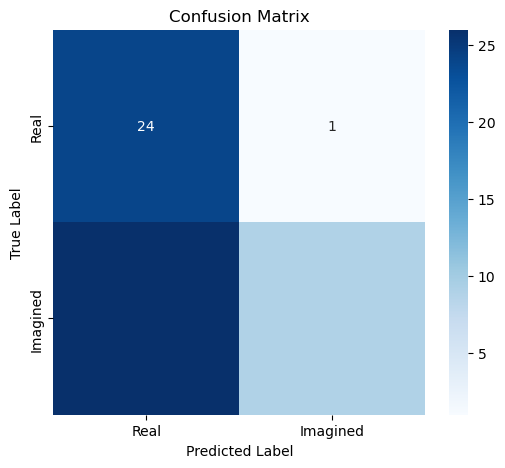

In [47]:
# SVM without CSP
subject = 1
selected_channels = ['Cz..','C4..','C3..','Cp4.','Cp3.']

output, labels = format_data(subject_data[subject-1], subject, selected_channels=selected_channels, filter_bands=(8,12))

X_train, X_test, y_train, y_test = train_test_split(
    output, labels, test_size=0.33, random_state=189)

clf = svm.SVC(kernel='linear', C=1)

# Check validation accuracy using cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_train, y_train, cv=cv)

print("Mean CV accuracy:", np.mean(scores))

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
results = np.multiply(predictions,y_test)  # Find errors

# Evaluate Model Performance
accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
class_report = classification_report(y_test, predictions)

print(f"Model Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# **Plot Confusion Matrix**
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d",
            xticklabels=["Real", "Imagined"], yticklabels=["Real", "Imagined"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

For subject 1, we can see that the SVM tends to overpredict imagined trials, but is otherwise relatively accurate. To improve our results, we can filter the signals using common spatial patterns (CSP) which maximize the variance between two classes. Our two classes, imagined and real motor imagery, need to be more distinguishable on all EEG channels, so this algorithm is perfect for improving the classifier accuracy.

In [48]:
import mne
from mne.decoding import CSP
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

mne.set_log_level('ERROR')

def filter_csp(data,subject,selected_channels='all',filter_bands=None,csp_n_components=4):
    """
    Do CSP filtering on the data of a given subject, along selected channels with optional filtering. 

    Inputs:
        data (np.array): The 3-d data for a single subject, or the 4-d data for all subjects
        subject (int): Which subject the data belongs to.
        selected_channels (optional, list or str): Which EEG channels to look at. Defaults to 'all'
        filter_bands (optional, tuple): The passbands for the filter.
        csp_n_components (optional, int): How many features the CSP extraction will output.

    Returns: 
        X_csp: A numpy array of CSP'd data.
        labels: The corresponding labels for X_csp.
    """
    if selected_channels == 'all':
        selected_channels = channels  # Use channels global var for all channel selection
    if len(data.shape) > 3:
        data = data[subject-1]
    # Get outputs in (E,SxC) shape and reshape to (E,C,S) for CSP
    output, labels = format_data(data, subject, selected_channels=selected_channels, filter_bands=filter_bands)
    
    E,SxC = output.shape
    C = len(selected_channels)
    S = int(SxC / C)
    epochs = np.reshape(output,(E,C,S))
    
    ch_types = ['eeg'] * C
    info = mne.create_info(ch_names=selected_channels, sfreq=fs, ch_types=ch_types)
    
    # Create MNE EpochsArray using event data
    events = np.column_stack((
        np.arange(0, E * fs*4, fs*4), 
        np.zeros(E, dtype=int),                         
        np.zeros(E, dtype=int)                    
    ))
    events[:,2] = labels
    
    epochs_mne = mne.EpochsArray(epochs, info, event_id=labels, events=events)

    # Convert event labels into integer codes
    le = LabelEncoder()
    y = le.fit_transform(labels)
    
    # Apply CSP
    csp = CSP(n_components=csp_n_components, reg=None, log=True, norm_trace=False)
    X_csp = csp.fit_transform(epochs_mne.get_data(), y)
    
    return X_csp, labels

def deploy_svm(data,labels,test_size=.33,plotting=True,subject=None):
    """
    Train and test on a support vector machine given the original data and labels. Automatically does train-test splitting.
    Optionally will print the confusion matrix.

    Inputs:
        data (np.array): The data to train and test on.
        labels (list): The list of labels for the data.
        test_size (float): The proportion of test data to train data.
        plotting (bool): Whether or not to plot the confusion matrix.
        subject (int): Which subject to print on the plot.

    Returns: 
        error: The error on the test set.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, test_size=test_size, random_state=189)
    
    clf = svm.SVC(kernel='linear', C=1)
    clf.fit(X_train, y_train)
    
    predictions = clf.predict(X_test)
    
    # Evaluate Model Performance
    accuracy = accuracy_score(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions)
    class_report = classification_report(y_test, predictions)
    
    # Plot Confusion Matrix
    if plotting:
        print(f"Model Accuracy: {accuracy:.4f}")
    
        plt.figure(figsize=(6, 5))
        sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d",
                    xticklabels=["Real", "Imagined"], yticklabels=["Real", "Imagined"])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix for Subject {subject}")
        plt.show()

    return accuracy

Model Accuracy: 0.7667


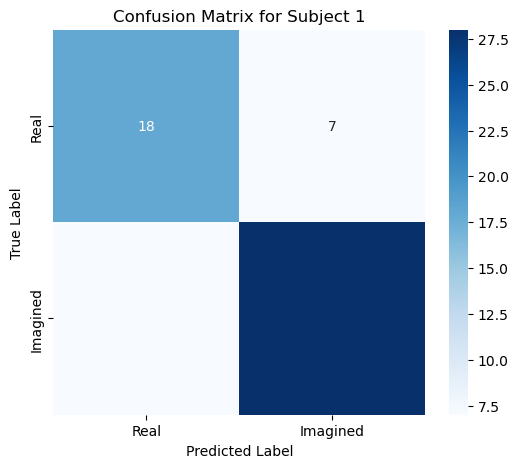

0.7666666666666667

In [49]:
# Example on using CSP and SVM together
subject = 1

X_csp, labels = filter_csp(subject_data[subject-1],subject,filter_bands=(8,12))
deploy_svm(X_csp,labels,plotting=True,subject=subject)

Our results on subject 1 suggest that, as we predicted, CSP does help us distinguish between the two classes, as the SVM has a much higher accuracy of 76%, with an equal number of Type 1 and Type 2 errors.

#### Plotting SVM results with different filtering and CSP on various channel combinations
Now, we can experiment with which frequencies are most important for classification and also see the effects of CSP when bandpass filtering. These results are ran on all subjects, with each subject training and testing a SVM, as individual EEG data doesn't tend to generalize well.

In [29]:
def plot_svm_accuracy(data,test_channels=['all'],subject_range=3,filter_bands=None,csp=False):
    bands = {(8,12):'alpha',(13,30):'beta',(30,79):'gamma'}
    accuracy_list = []
    channels_list = []
    subject_count = subject_range

    for selected_channels in test_channels:
        if selected_channels == 'all':
            channels_list.append(selected_channels)
        else:
            channels_list.append("/".join(selected_channels).replace(".", ""))

    for subject in range(1,subject_range+1):
        exception = False
        accuracy = []
        for selected_channels in test_channels:
            try:
                if csp:
                    X_csp, labels = filter_csp(subject_data,subject,selected_channels=selected_channels,filter_bands=filter_bands)
                    acc = deploy_svm(X_csp,labels,plotting=False,subject=subject)
                else:
                    X, labels = format_data(subject_data,subject,selected_channels=selected_channels,filter_bands=filter_bands)
                    acc = deploy_svm(X,labels,plotting=False,subject=subject)
            except np.linalg.LinAlgError:
                exception = True
                break

            accuracy.append(acc)

        if exception:
            print(f'Exception thrown for subject {subject}')
            subject_count -= 1
            continue

        accuracy = np.array(accuracy)
        accuracy_list.append(accuracy)

    df = pd.DataFrame(np.array(accuracy_list))
    df.columns = channels_list
    df_melted = df.melt(var_name='Channels', value_name='Accuracy')
    
    plt.figure(figsize=(10, 6))

    for i in range(len(channels_list)):
        sns.barplot(x='Channels', y='Accuracy', data=df_melted, errorbar='sd', capsize=0.1, palette='Blues')

    if filter_bands in bands and csp:
        plt.title(f"Accuracy of {bands[filter_bands]}-filtered, CSP based SVM classification vs. channel selection")
    elif csp:
        plt.title(f"Accuracy of CSP based SVM classification vs. channel selection")
    elif filter_bands in bands:
        plt.title(f"Accuracy of {bands[filter_bands]}-filtered SVM classification vs. channel selection")
    else:
        plt.title(f"Accuracy of SVM classification vs. channel selection")

    plt.tight_layout()
    plt.grid(axis="y")
    plt.show()
    print(f'Tested on {subject_count} subjects')

In [51]:
bands = {'alpha':(8,12),'beta':(13,30),'gamma':(30,79)}

# Modify these to try different combinations
test_channels = [
    'all',
    ['Cz..','C4..','C3..','Cp4.','Cp3.','Fc3.','Fc4.','Fcz.'],
    ['Cz..','C4..','C3..']
]

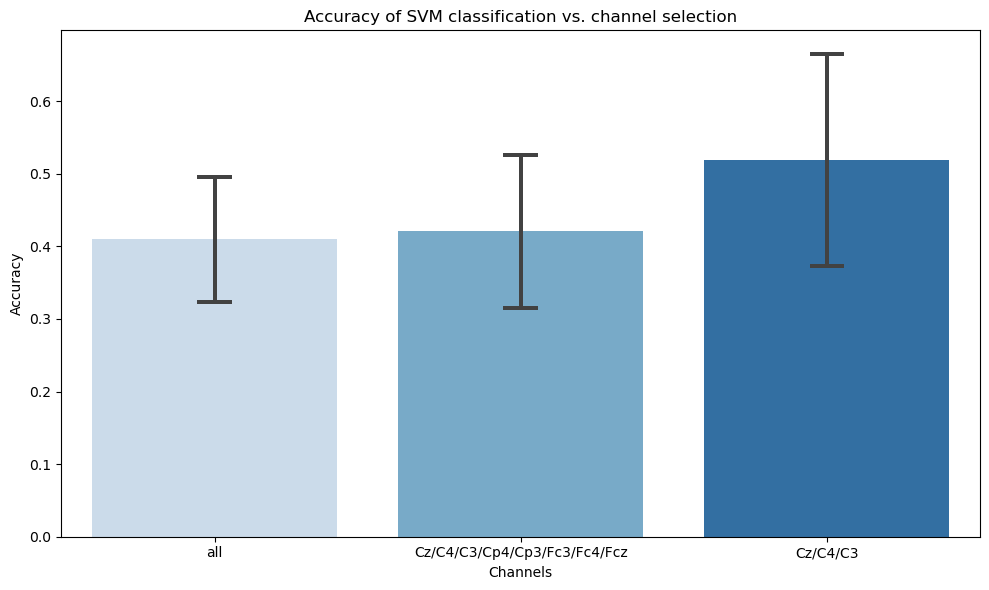

Tested on 109 subjects


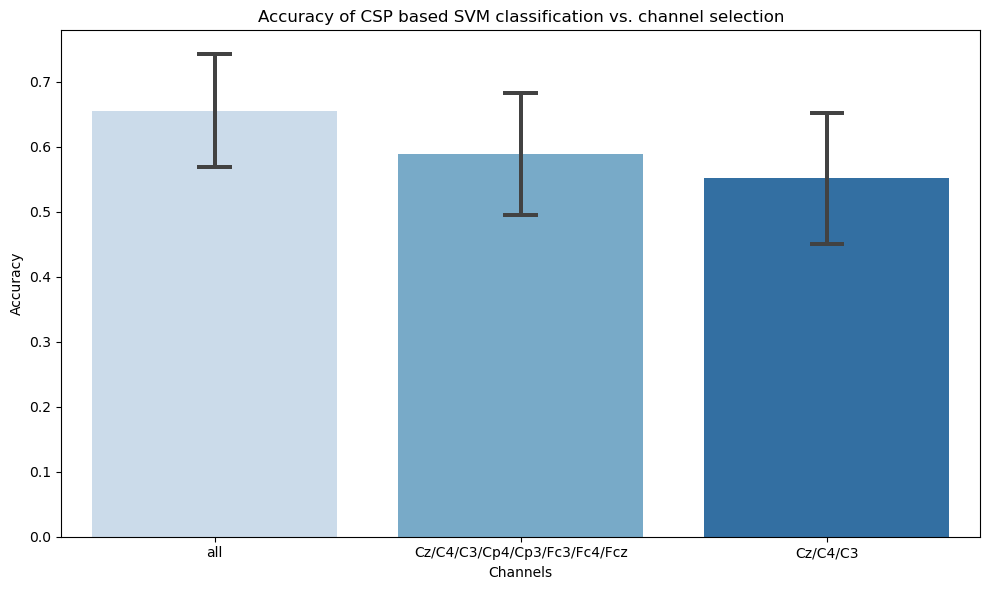

Tested on 109 subjects


In [31]:
plot_svm_accuracy(subject_data,test_channels=test_channels,subject_range=109)
plot_svm_accuracy(subject_data,test_channels=test_channels,subject_range=109,csp=True)

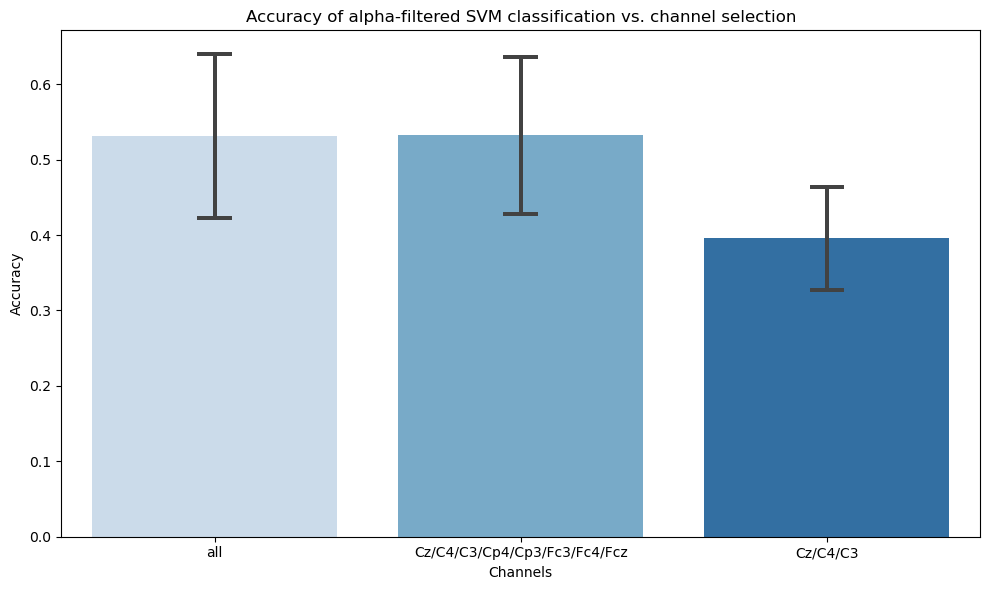

Tested on 109 subjects
Exception thrown for subject 88
Exception thrown for subject 92


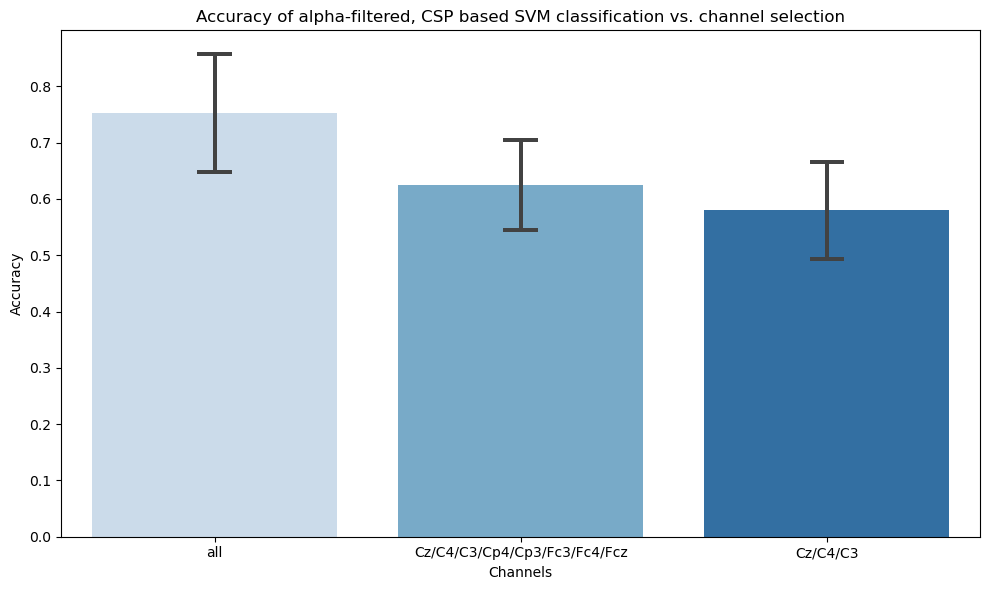

Tested on 107 subjects


In [32]:
plot_svm_accuracy(subject_data,test_channels=test_channels,filter_bands=bands['alpha'],subject_range=109)
plot_svm_accuracy(subject_data,test_channels=test_channels,filter_bands=bands['alpha'],csp=True,subject_range=109)

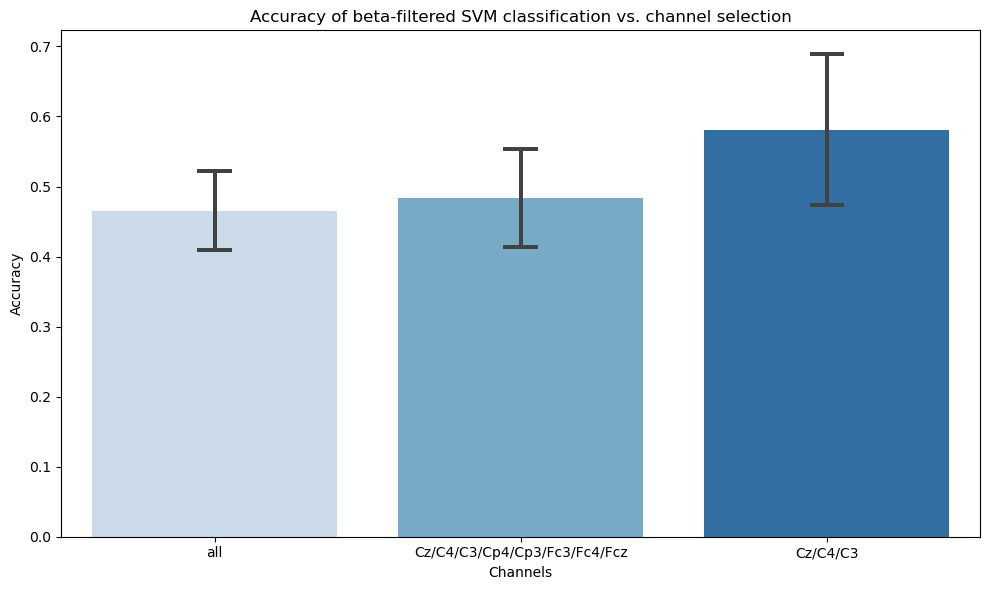

Tested on 109 subjects


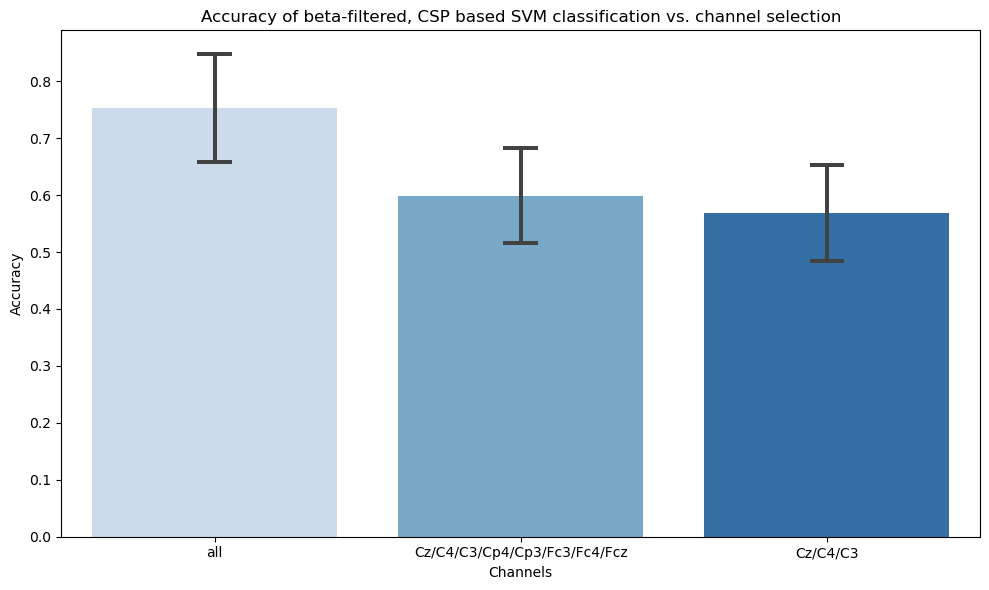

Tested on 109 subjects


In [33]:
plot_svm_accuracy(subject_data,test_channels=test_channels,filter_bands=bands['beta'],subject_range=109)
plot_svm_accuracy(subject_data,test_channels=test_channels,filter_bands=bands['beta'],csp=True,subject_range=109)

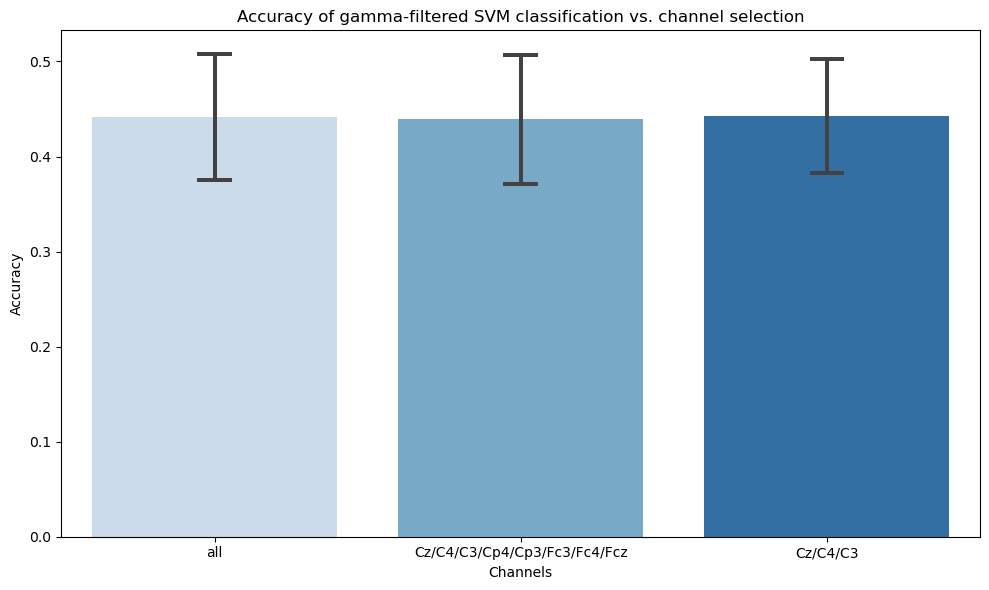

Tested on 109 subjects


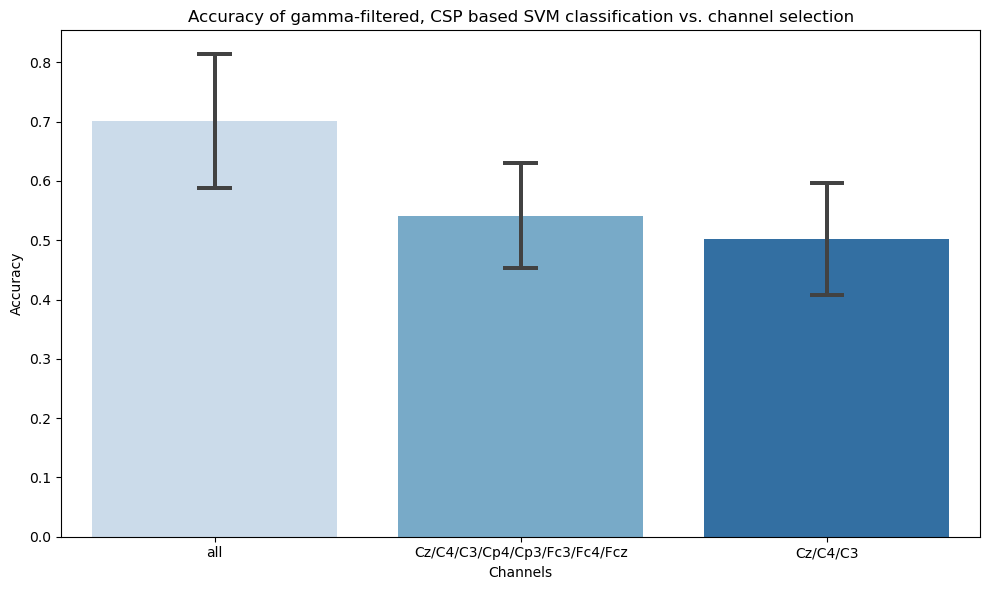

Tested on 109 subjects


In [34]:
plot_svm_accuracy(subject_data,test_channels=test_channels,filter_bands=bands['gamma'],subject_range=109)
plot_svm_accuracy(subject_data,test_channels=test_channels,filter_bands=bands['gamma'],csp=True,subject_range=109)

TODO results

## Signal Power Analysis
We also experimented with the power associated with the Alpha and Beta bands as a potential method of classification. Below are the plotted log powers of each trial, filtered by bands and categorized by which event it represents (resting, real, or imagined).

There seem to be patterns differentiating resting and real/imagined movement, but not a lot of variability when it comes to distinguishing real and imagined movement across the same frequency band. The SVM results also corroborate this observation, as the classifier is not nearly as good as the previous temporal classifier.

Processing trial 1 for Subject 1
Alpha Raw Data Sample:
             C4..       C3..      Cz..
0.00000 -2.471627  -3.657195 -2.724470
0.00625 -5.156806 -10.602210 -5.974982
0.01250 -7.300248 -15.742785 -8.252567
0.01875 -8.597359 -18.115265 -8.999831
0.02500 -8.849555 -17.276829 -7.964111
Alpha Variance: [ 97.52136591 138.98086465 123.41661215]
Alpha Log Power: [4.58007149 4.93433626 4.81556572]
Processing trial 2 for Subject 1
Alpha Raw Data Sample:
              C4..      C3..       Cz..
0.00000  -0.368190 -2.181558  -1.376747
0.00625   5.218156  1.770635   5.218674
0.01250   9.911210  5.228885  10.845402
0.01875  12.886726  7.500665  14.469401
0.02500  13.629694  8.141700  15.432733
Alpha Variance: [443.78919852 520.16282448 591.22422012]
Alpha Log Power: [6.09534967 6.25414189 6.38219534]
Processing trial 3 for Subject 1
Alpha Raw Data Sample:
             C4..      C3..      Cz..
0.00000 -0.859451 -2.433460 -2.163327
0.00625 -4.304429 -4.905365 -4.972456
0.01250 -6.725448 -6.40901

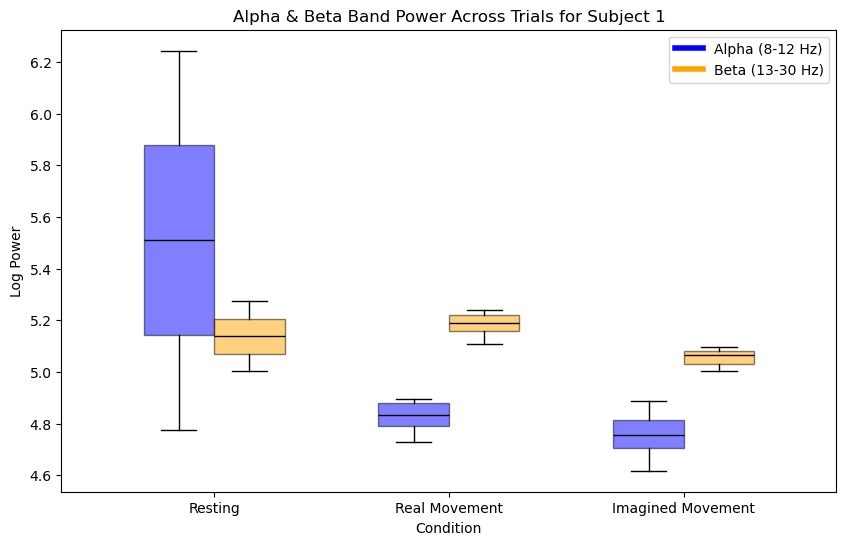

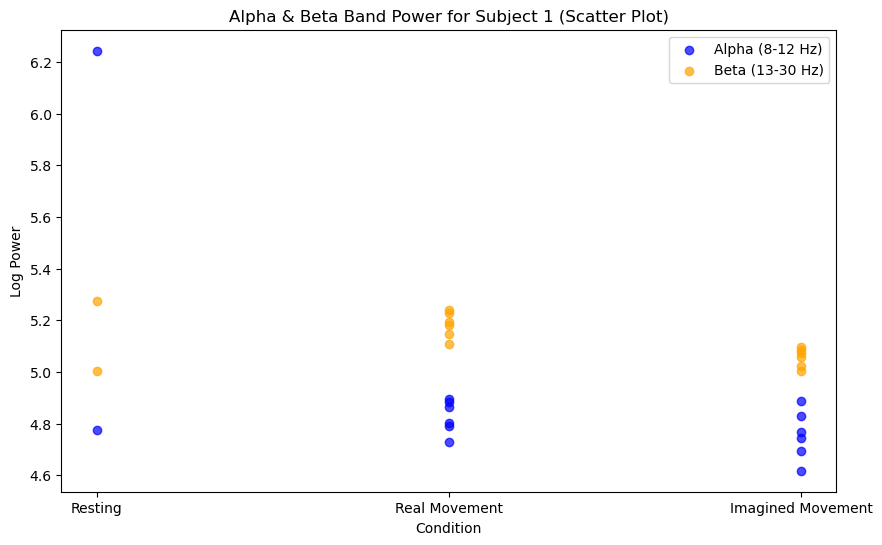

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import wfdb

# Define motor movement categories
resting_runs = [1, 2]  
real_movement_runs = [3, 5, 7, 9, 11, 13]  
imagined_movement_runs = [4, 6, 8, 10, 12, 14]  

# Initialize lists for trial-level data
alpha_power_list = []
beta_power_list = []
labels_list = []

# Process only Subject 1
subject = 1  

# Loop through only Subject 1's trials
for trial in range(1, 15):  

    file_path = path + f"S{subject:03}/S{subject:03}R{trial:02}.edf"

    try:
        # Read EEG annotations
        annotations = wfdb.rdann(file_path, 'event')
        samples = annotations.sample
        notes = annotations.aux_note

        # Load the EEG data for this trial
        raw = mne.io.read_raw_edf(file_path, preload=True)  # Load EDF file
        df = raw.to_data_frame()  # Convert to DataFrame
        df.set_index(raw.times, inplace=True)  # Set time index

        # Ensure the selected channels exist in the loaded EEG data
        selected_channels = df[motor_channels]

        # Apply bandpass filters
        sos_alpha = butter_bandpass(8, 12, fs, order=10)
        sos_beta = butter_bandpass(13, 30, fs, order=10)

        alpha_df = selected_channels.apply(lambda x: sosfiltfilt(sos_alpha, x))
        beta_df = selected_channels.apply(lambda x: sosfiltfilt(sos_beta, x))

        print(f"Processing trial {trial} for Subject {subject}")
        print(f"Alpha Raw Data Sample:\n{alpha_df.head()}")  # Check if EEG signals change across trials
        print(f"Alpha Variance: {np.var(alpha_df.values, axis=0)}")  # Ensure variance isn't constant
        print(f"Alpha Log Power: {np.log(np.var(alpha_df.values, axis=0))}")  # Ensure log power is changing


        # Compute power per trial (NO AVERAGING)
        alpha_power = np.log(np.var(alpha_df.values, axis=0))  
        beta_power = np.log(np.var(beta_df.values, axis=0))

        # Assign labels based on trial number
        if trial in resting_runs:
            trial_label = 0  # Resting
        elif trial in real_movement_runs:
            trial_label = 1  # Real Movement
        elif trial in imagined_movement_runs:
            trial_label = 2  # Imagined Movement
        else:
            continue  

        # Append the trial-level power values
        alpha_power_list.append(alpha_power.mean())  # Ensure single value per trial
        beta_power_list.append(beta_power.mean())  
        labels_list.append(trial_label)

    except:
        print(f"Skipping missing file: {file_path}")
        continue

# Convert lists to arrays
alpha_power = np.array(alpha_power_list)
beta_power = np.array(beta_power_list)
labels = np.array(labels_list)

# Check label distribution
print("Label Counts:", np.bincount(labels))

# Define conditions
conditions = ["Resting", "Real Movement", "Imagined Movement"]

# **Create lists for each condition**
alpha_data = [alpha_power[labels == i] for i in range(3)]
beta_data = [beta_power[labels == i] for i in range(3)]

print("Alpha Power (Resting):", alpha_power[labels == 0])
print("Alpha Power (Real):", alpha_power[labels == 1])
print("Alpha Power (Imagined):", alpha_power[labels == 2])

print("Beta Power (Resting):", beta_power[labels == 0])
print("Beta Power (Real):", beta_power[labels == 1])
print("Beta Power (Imagined):", beta_power[labels == 2])


# Boxplot for better trial-level visualization
plt.figure(figsize=(10, 6))

# Alpha band boxplot (blue)
plt.boxplot(alpha_data, positions=np.arange(3) - 0.15, widths=0.3, patch_artist=True,
            boxprops=dict(facecolor="blue", alpha=0.5), medianprops=dict(color="black"))

# Beta band boxplot (orange)
plt.boxplot(beta_data, positions=np.arange(3) + 0.15, widths=0.3, patch_artist=True,
            boxprops=dict(facecolor="orange", alpha=0.5), medianprops=dict(color="black"))

# Labels and title
plt.xlabel("Condition")
plt.ylabel("Log Power")
plt.title("Alpha & Beta Band Power Across Trials for Subject 1")
plt.xticks(range(3), conditions)  

# Fix the legend
custom_lines = [
    plt.Line2D([0], [0], color="blue", lw=4, label="Alpha (8-12 Hz)"),
    plt.Line2D([0], [0], color="orange", lw=4, label="Beta (13-30 Hz)")
]
plt.legend(handles=custom_lines)

# Show plot
plt.show()

plt.figure(figsize=(10, 6))

for condition, label in enumerate(conditions):
    plt.scatter(
        [condition] * np.sum(labels == condition),
        alpha_power[labels == condition],
        color="blue", label="Alpha (8-12 Hz)" if condition == 0 else "", alpha=0.7
    )
    plt.scatter(
        [condition] * np.sum(labels == condition),
        beta_power[labels == condition],
        color="orange", label="Beta (13-30 Hz)" if condition == 0 else "", alpha=0.7
    )

plt.xlabel("Condition")
plt.ylabel("Log Power")
plt.title("Alpha & Beta Band Power for Subject 1 (Scatter Plot)")
plt.xticks(range(3), conditions)
plt.legend()
plt.show()

Label Counts: [218 654 654]


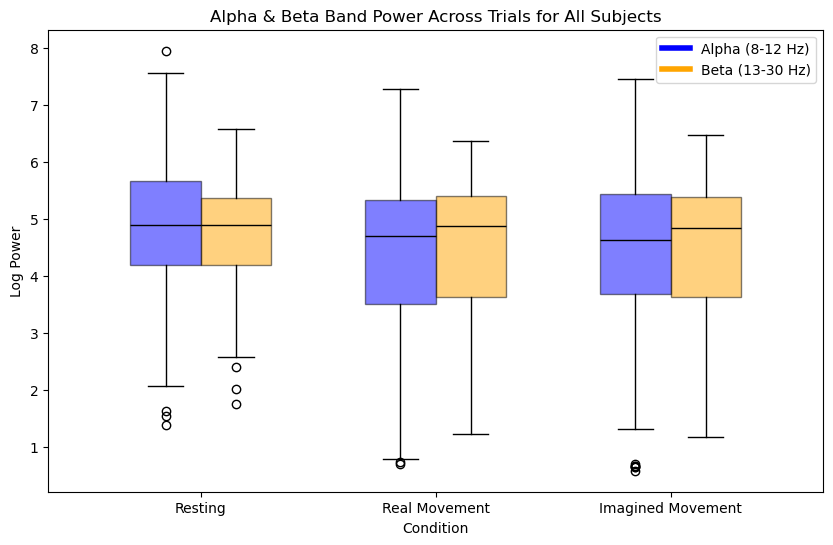

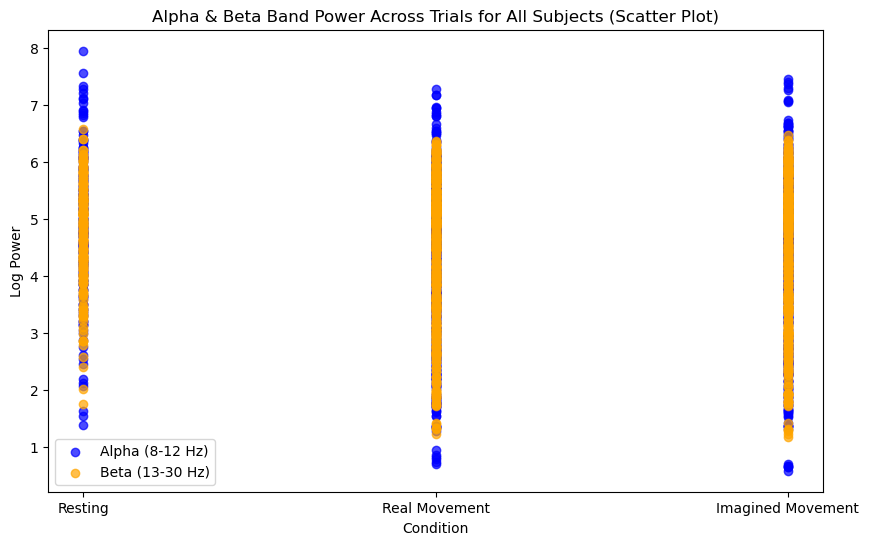

In [37]:
# Define motor movement categories
resting_runs = [1, 2]  
real_movement_runs = [3, 5, 7, 9, 11, 13]  
imagined_movement_runs = [4, 6, 8, 10, 12, 14]  

# Initialize lists for trial-level data across all subjects
alpha_power_list = []
beta_power_list = []
labels_list = []

# Loop through all 109 subjects
for subject in range(1, 110):  

    # Loop through all trials for the current subject
    for trial in range(1, 15):  
        file_path = path + f"/S{subject:03}/S{subject:03}R{trial:02}.edf"

        try:
            # Read EEG annotations
            annotations = wfdb.rdann(file_path, 'event')
            samples = annotations.sample
            notes = annotations.aux_note

            # Load the EEG data for this trial
            raw = mne.io.read_raw_edf(file_path, preload=True)  # Load EDF file
            df = raw.to_data_frame()  # Convert to DataFrame
            df.set_index(raw.times, inplace=True)  # Set time index

            # Select motor-related EEG channels
            motor_channels = ["C3..", "C4..", "Cz.."]  # Common motor imagery channels
            selected_channels = df[motor_channels]

            # Apply bandpass filters
            sos_alpha = butter_bandpass(8, 12, raw.info["sfreq"], order=10)
            sos_beta = butter_bandpass(13, 30, raw.info["sfreq"], order=10)

            alpha_df = selected_channels.apply(lambda x: sosfiltfilt(sos_alpha, x))
            beta_df = selected_channels.apply(lambda x: sosfiltfilt(sos_beta, x))

            # Compute power per trial (NO AVERAGING across subjects)
            alpha_power = np.log(np.var(alpha_df.values, axis=0))  
            beta_power = np.log(np.var(beta_df.values, axis=0))

            # Assign labels based on trial number
            if trial in resting_runs:
                trial_label = 0  # Resting
            elif trial in real_movement_runs:
                trial_label = 1  # Real Movement
            elif trial in imagined_movement_runs:
                trial_label = 2  # Imagined Movement
            else:
                continue  

            # Append the trial-level power values
            alpha_power_list.append(alpha_power.mean())  # Mean across selected channels
            beta_power_list.append(beta_power.mean())  
            labels_list.append(trial_label)

        except:
            print(f"Skipping missing file: {file_path}")
            continue

# Convert lists to arrays
alpha_power = np.array(alpha_power_list)
beta_power = np.array(beta_power_list)
labels = np.array(labels_list)

# Check label distribution
print("Label Counts:", np.bincount(labels))

# Define conditions
conditions = ["Resting", "Real Movement", "Imagined Movement"]

# Create lists for each condition
alpha_data = [alpha_power[labels == i] for i in range(3)]
beta_data = [beta_power[labels == i] for i in range(3)]

# Boxplot for better trial-level visualization across all subjects
plt.figure(figsize=(10, 6))

# Alpha band boxplot (blue)
plt.boxplot(alpha_data, positions=np.arange(3) - 0.15, widths=0.3, patch_artist=True,
            boxprops=dict(facecolor="blue", alpha=0.5), medianprops=dict(color="black"))

# Beta band boxplot (orange)
plt.boxplot(beta_data, positions=np.arange(3) + 0.15, widths=0.3, patch_artist=True,
            boxprops=dict(facecolor="orange", alpha=0.5), medianprops=dict(color="black"))

# Labels and title
plt.xlabel("Condition")
plt.ylabel("Log Power")
plt.title("Alpha & Beta Band Power Across Trials for All Subjects")
plt.xticks(range(3), conditions)  

# Fix the legend
custom_lines = [
    plt.Line2D([0], [0], color="blue", lw=4, label="Alpha (8-12 Hz)"),
    plt.Line2D([0], [0], color="orange", lw=4, label="Beta (13-30 Hz)")
]
plt.legend(handles=custom_lines)

# Show plot
plt.show()


# Scatter plot to see trial-level variation across subjects
plt.figure(figsize=(10, 6))

for condition, label in enumerate(conditions):
    plt.scatter(
        [condition] * np.sum(labels == condition),
        alpha_power[labels == condition],
        color="blue", label="Alpha (8-12 Hz)" if condition == 0 else "", alpha=0.7
    )
    plt.scatter(
        [condition] * np.sum(labels == condition),
        beta_power[labels == condition],
        color="orange", label="Beta (13-30 Hz)" if condition == 0 else "", alpha=0.7
    )

plt.xlabel("Condition")
plt.ylabel("Log Power")
plt.title("Alpha & Beta Band Power Across Trials for All Subjects (Scatter Plot)")
plt.xticks(range(3), conditions)
plt.legend()
plt.show()


## SVM Frequency Plot Analysis


Processing Subject 1...
  Training on Alpha band...
  Training on Beta band...
  Training on Gamma band...

Processing Subject 2...
  Training on Alpha band...
  Training on Beta band...
  Training on Gamma band...

Processing Subject 3...
  Training on Alpha band...
  Training on Beta band...
  Training on Gamma band...

Processing Subject 4...
  Training on Alpha band...
  Training on Beta band...
  Training on Gamma band...

Processing Subject 5...
  Training on Alpha band...
  Training on Beta band...
  Training on Gamma band...

Processing Subject 6...
  Training on Alpha band...
  Training on Beta band...
  Training on Gamma band...

Processing Subject 7...
  Training on Alpha band...
  Training on Beta band...
  Training on Gamma band...

Processing Subject 8...
  Training on Alpha band...
  Training on Beta band...
  Training on Gamma band...

Processing Subject 9...
  Training on Alpha band...
  Training on Beta band...
  Training on Gamma band...

Processing Subject 10...
  

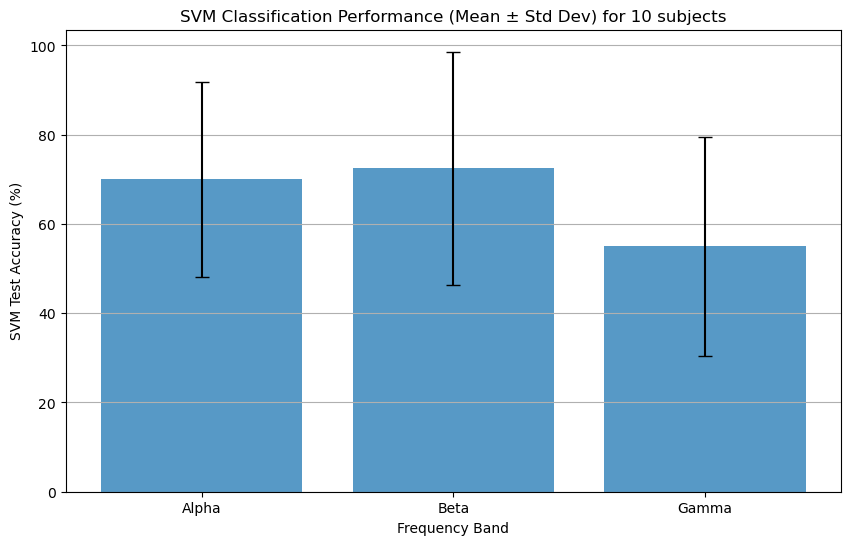

In [82]:
from sklearn.preprocessing import StandardScaler

# Frequency bands (Hz)
freq_bands = {
    "Alpha": (8, 12),
    "Beta": (12, 30),
    "Gamma": (30, 97)
}

num_subjects = 10 
num_trials = 14 

results = {band: [] for band in freq_bands.keys()}  

# Function to compute Power Spectral Density
def compute_psd(eeg_data, sfreq, band):
    fmin, fmax = band
    freqs, psd = welch(eeg_data, sfreq, nperseg=256, axis=1)
    band_power = psd[:, (freqs >= fmin) & (freqs <= fmax)]
    band_power = np.reshape(band_power,(-1,1))
    band_power = band_power.squeeze()
    return band_power

# Loop over subjects
for subject_id in range(num_subjects):  
    print(f"\nProcessing Subject {subject_id + 1}...")

    for band_name, band_range in freq_bands.items():
        print(f"  Training on {band_name} band...")

        X_band = []
        y = []

        # Extract features for each trial
        for trial in range(num_trials):
            eeg_trial = subject_data[subject_id, trial, :, :]  

            # Assign trial labels (T0 = rest, T1 = real movement, T2 = imagined movement)
            if trial in [2, 4, 6, 8, 10, 12]:  # Real movement trials
                label = 1  # T1
            elif trial in [3, 5, 7, 9, 11, 13]:  # Imagined movement trials
                label = 2  # T2
            else:
                continue

            band_power = compute_psd(eeg_trial, 160, band_range)  
            X_band.append(band_power)
            y.append(label)

        X_band = np.array(X_band)
        y = np.array(y)

        # Normalize 
        scaler = StandardScaler()
        X_band = scaler.fit_transform(X_band)

        # Train/Test Split (70% train, 30% test)
        X_train, X_test, y_train, y_test = train_test_split(X_band, y, test_size=0.3, random_state=42)

        # Train SVM Model
        svm_band = svm.SVC(kernel='linear', C=1)
        svm_band.fit(X_train, y_train)

        # Test the model
        test_accuracy = svm_band.score(X_test, y_test)
        cv_scores = cross_val_score(svm_band, X_band, y, cv=5)

        results[band_name].append(test_accuracy * 100)

plt.figure(figsize=(10, 6))
mean_accuracies = [np.mean(acc) for acc in results.values()]
std_accuracies = [np.std(acc) for acc in results.values()]
plt.bar(results.keys(), mean_accuracies, yerr=std_accuracies, capsize=5, alpha=0.75)
plt.xlabel("Frequency Band")
plt.ylabel("SVM Test Accuracy (%)")
plt.title("SVM Classification Performance (Mean ± Std Dev) for 10 subjects")
plt.grid(axis="y")
plt.show()